In [70]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [71]:
import numpy
import torch
import typing

from holo.prettyFormats import prettyPrint
from holo.__typing import assertIsinstance

In [72]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")

using device: cuda:0


In [73]:
import handleDatas
import train
import basicModels
import MoE_models
import MoE_models.paper1

def cell():
    global handleDatas, train, MoE_models, basicModels
    import importlib
    handleDatas = importlib.reload(handleDatas)
    train = importlib.reload(train)
    basicModels = importlib.reload(basicModels)
    MoE_models.paper1 = importlib.reload(MoE_models.paper1)

cell();

In [74]:
#datashandler = handleDatas.Cifar100_Datas(
#    fromTrainSource=None, maxSamples=None, trainProp=0.8,
#    batchSizeTrain=256, batchSizeTest=256)

datasHandler = handleDatas.HandleImagesClassifDatas.merge(
    #handleDatas.MNIST_Datas(
    #    fromTrainSource=None, maxSamples=None, trainProp=0.8, batchSizeTrain=256, batchSizeTest=256),
    #handleDatas.FashionMNIST_Datas(
    #    fromTrainSource=None, maxSamples=None, trainProp=0.8, batchSizeTrain=256, batchSizeTest=256),
    handleDatas.Cifar10_Datas(
        fromTrainSource=None, maxSamples=None, trainProp=0.8, batchSizeTrain=256, batchSizeTest=256),
    #handleDatas.Cifar100_Datas(
    #    fromTrainSource=None, maxSamples=None, trainProp=0.8, batchSizeTrain=256, batchSizeTest=256),
    trainProp=0.8, batchSizeTrain=256, batchSizeTest=256)

loaded Cifar10(total: 60000), train: 48000 [188 batches] | test: 12000 [47 batches]
loaded Merged[Cifar10](total: 60000), train: 48000 [188 batches] | test: 12000 [47 batches]


In [ ]:
def cell():
    gatingModel, experts, loss = basicModels.BasicImageClassifModel.get_Cifar_like_32x32x3_moe(
        device=device, nbClasses=datasHandler.nbClasses, 
        gatingModelConfig='small', nbExperts=6, expertsModelConfig="small")
    moeModel = MoE_models.paper1.MOE_Model(
        experts=experts, gatingModel=gatingModel,
        isClassif=True, loadBalance=False, useVersion="logLikelihood", topK=None)
    return moeModel, loss
model, baseLoss = cell(); del cell
hist = train.HistoryClassification()
optim = torch.optim.AdamW(model.parameters(), lr=0.001)

print(f"nbParams total: {basicModels.countTotalParameters(model.parameters()):_d}")
print(f"nbParams gating: {basicModels.countTotalParameters(model.gatingModel.parameters()):_d}")
print(f"""nbParams experts: [{', '.join([f"{basicModels.countTotalParameters(expert.parameters()):_d}" for expert in model.experts])}]""")

trainer = train.TrainerClassif_MoE1(model=model, optimizer=optim, criterion=baseLoss, device=device)

# test the model
_ = model(datasHandler.full_dataset[0]['image'].to(device)[None, ...].repeat((1, 1, 1, 1)))
assert _[1].shape == (1, datasHandler.nbClasses, model.nbExperts), f"{_[1].shape = }"
#print(_[0].detach().cpu().numpy())
#print(_[1].detach().cpu().numpy())
#print(_[2].detach().cpu().numpy())

nbParams total: 223_458
nbParams gating: 29_286
nbParams experts: [32_362, 32_362, 32_362, 32_362, 32_362, 32_362]


In [91]:
trainer.train_model_classif(datasHandler=datasHandler, nbEpoches=20);

Epoch 11, train: (loss: 0.6824, accuracy: 76.25%), test: (loss: 0.9092, accuracy: 68.00%), lr: 1.0000e-03
Epoch 12, train: (loss: 0.6495, accuracy: 77.10%), test: (loss: 0.8397, accuracy: 70.93%), lr: 1.0000e-03
Epoch 13, train: (loss: 0.6284, accuracy: 77.90%), test: (loss: 0.8367, accuracy: 71.19%), lr: 1.0000e-03
Epoch 14, train: (loss: 0.6047, accuracy: 78.41%), test: (loss: 0.8941, accuracy: 69.40%), lr: 1.0000e-03
Epoch 15, train: (loss: 0.5834, accuracy: 79.68%), test: (loss: 1.002, accuracy: 65.71%), lr: 1.0000e-03
Epoch 16, train: (loss: 0.5681, accuracy: 80.16%), test: (loss: 0.828, accuracy: 71.03%), lr: 1.0000e-03
Epoch 17, train: (loss: 0.5492, accuracy: 80.41%), test: (loss: 0.7816, accuracy: 73.29%), lr: 1.0000e-03
Epoch 18, train: (loss: 0.5243, accuracy: 81.40%), test: (loss: 0.7979, accuracy: 72.86%), lr: 1.0000e-03
Epoch 19, train: (loss: 0.5083, accuracy: 81.89%), test: (loss: 0.8401, accuracy: 71.83%), lr: 1.0000e-03
Epoch 20, train: (loss: 0.4895, accuracy: 82.92%

In [94]:
print(("\n" + ' '*8).join(map(str, trainer.history)))
def cell():
    bestTrain = trainer.history[max(range(len(trainer.history)), key=lambda i:trainer.history[i].train.accuracy())]
    bestTest = trainer.history[max(range(len(trainer.history)), key=lambda i:trainer.history[i].test.accuracy())]
    print(' ' * 4 + f"-> best accuracy, train: {bestTrain.train.accuracy():.2%} (epoch {bestTrain.epochID}), "
          f"test: {bestTest.test.accuracy():.2%} (epoch {bestTest.epochID})")
cell(); del cell

Epoch 1, train: (loss: 1.546, accuracy: 44.32%), test: (loss: 1.35, accuracy: 51.20%), lr: 1.0000e-03
        Epoch 2, train: (loss: 1.206, accuracy: 57.16%), test: (loss: 1.173, accuracy: 59.08%), lr: 1.0000e-03
        Epoch 3, train: (loss: 1.07, accuracy: 62.09%), test: (loss: 1.266, accuracy: 56.61%), lr: 1.0000e-03
        Epoch 4, train: (loss: 0.9825, accuracy: 65.50%), test: (loss: 1.009, accuracy: 64.73%), lr: 1.0000e-03
        Epoch 5, train: (loss: 0.9126, accuracy: 67.98%), test: (loss: 1.175, accuracy: 60.43%), lr: 1.0000e-03
        Epoch 6, train: (loss: 0.8551, accuracy: 70.06%), test: (loss: 0.9633, accuracy: 66.60%), lr: 1.0000e-03
        Epoch 7, train: (loss: 0.8154, accuracy: 71.41%), test: (loss: 0.9211, accuracy: 67.53%), lr: 1.0000e-03
        Epoch 8, train: (loss: 0.7711, accuracy: 73.04%), test: (loss: 0.9429, accuracy: 66.77%), lr: 1.0000e-03
        Epoch 9, train: (loss: 0.7386, accuracy: 74.11%), test: (loss: 1.015, accuracy: 65.20%), lr: 1.0000e-03
  

In [92]:
def cell():
    
    htest = assertIsinstance(train.Moe1ExpertsInsigths, trainer.history[-1].test.moeExpertsInsigths)
    print(f"-> RESULT")
    print(f"mean: {htest.meanExpertsGate().round(3)} (std: {htest.meanExpertsGate().std(axis=0).round(3)})")
    print(f"std: {htest.meanPredClassesExpertsGate().std(axis=0).round(3)} (mean: {htest.meanPredClassesExpertsGate().std(axis=0).mean().round(3)})")
    print(f"perClassPred: \n{htest.meanPredClassesExpertsGate().round(2).T}")
    print("\n")
    
    rnd = 2
    with numpy.printoptions(threshold=100_000, linewidth=100_000):
        for h in trainer.history:
            htest = assertIsinstance(train.Moe1ExpertsInsigths, h.test.moeExpertsInsigths)
            htrain = assertIsinstance(train.Moe1ExpertsInsigths, h.train.moeExpertsInsigths)
            print(" ->", h.epochID)
            #print(htest.nbPred.round(rnd))
            #print(htest.nbTruth.round(rnd))
            print("delta (nbPred-nbTruth) per class[test]:\n ", (htest.nbPred - htest.nbTruth), sep="")
            print("mean experts use[train]: ", htrain.meanExpertsGate().round(rnd), sep="")
            print("mean experts use[test]: ", htest.meanExpertsGate().round(rnd), sep="")
            print("mean experts use per class predicted [test]:\n", htest.meanPredClassesExpertsGate().round(rnd).T, sep="")
            print("std experts use acros classes [test]:\n ", htest.meanPredClassesExpertsGate().std(axis=0).round(rnd), sep="")
            #print(htest.meanTruthClassesExpertsGate().round(rnd).T)
            #print((htest.meanPredClassesExpertsGate() - htest.meanTruthClassesExpertsGate()).round(rnd).T)
            print()
    

cell(); del cell

-> RESULT
mean: [0.021 0.03  0.144 0.153 0.456 0.197] (std: 0.145)
std: [0.065 0.063 0.164 0.149 0.319 0.192] (mean: 0.159)
perClassPred: 
[[0.   0.   0.01 0.01 0.22 0.   0.01 0.   0.   0.  ]
 [0.01 0.   0.22 0.01 0.01 0.01 0.01 0.   0.   0.  ]
 [0.58 0.01 0.27 0.06 0.16 0.05 0.14 0.11 0.05 0.02]
 [0.2  0.01 0.25 0.13 0.1  0.15 0.05 0.06 0.54 0.01]
 [0.19 0.97 0.15 0.29 0.41 0.26 0.54 0.78 0.06 0.96]
 [0.02 0.01 0.11 0.5  0.1  0.53 0.25 0.05 0.36 0.01]]


 -> 1
delta (nbPred-nbTruth) per class[test]:
 [-175  386 -665 -267 -474  846  397  246 -261  -33]
mean experts use[train]: [0.02 0.04 0.12 0.17 0.49 0.15]
mean experts use[test]: [0.02 0.03 0.14 0.2  0.52 0.09]
mean experts use per class predicted [test]:
[[0.   0.   0.02 0.02 0.05 0.02 0.03 0.01 0.   0.  ]
 [0.03 0.   0.13 0.03 0.07 0.05 0.01 0.01 0.04 0.  ]
 [0.38 0.05 0.23 0.15 0.2  0.17 0.07 0.06 0.25 0.04]
 [0.39 0.05 0.46 0.21 0.24 0.29 0.07 0.06 0.52 0.05]
 [0.15 0.87 0.1  0.45 0.31 0.28 0.74 0.81 0.1  0.88]
 [0.04 0.03 0.07 0

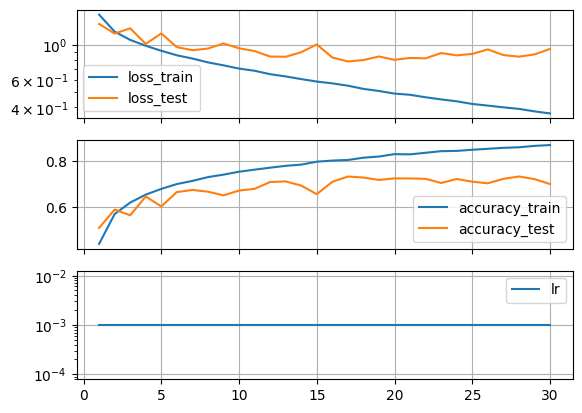

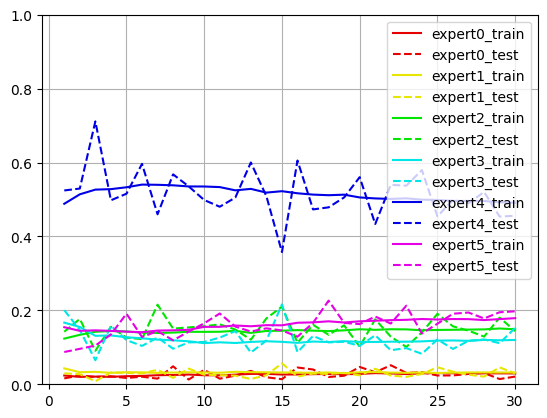

In [93]:
trainer.history.plot()
trainer.history.plotMoe1Insigths()

In [95]:
def cell():
    conf = trainer.history[-1].test.confusionMatrix
    #print(conf.matrix[0, :].T)
    #print(conf.matrix[65, 65], conf.matrix[65, :])
    
    with numpy.printoptions(threshold=100_000, linewidth=100_000):
        print(conf.matrix)
    print()

    for clsIndex in range(datasHandler.nbClasses):
        print(f"class: {clsIndex}, precision:{conf.classPrecision(clsIndex):.2%}, "
              f"hitRate: {conf.classHitRate(clsIndex):.2%}")
    print()
    
    prettyPrint(conf.worstK_confusions(10), 
                specificCompact={tuple}, specificFormats={numpy.float64:lambda x:f"{x:.4g}"})
cell(); del cell

[[ 890   29   49   17   32    8   16   26   72   42]
 [  10 1038   12    7   13    4   24    3   14   63]
 [ 118    9  799   97  166   77   77   55   22    4]
 [  29   18   93  747   97  261  167   63   45   10]
 [  15    3   52   44  665   39   77   37   10    2]
 [   5    7   53  150   46  654   56   51   14    6]
 [  28    2   63   75   38   35  738   10   15    4]
 [  17    4   37   42  114   64   25  966    7    6]
 [  72   26   24   19   20    9   14    5  953   37]
 [  31   86   16   32    7   19   24   26   24  957]]

class: 0, precision:75.36%, hitRate: 73.25%
class: 1, precision:87.37%, hitRate: 84.94%
class: 2, precision:56.11%, hitRate: 66.69%
class: 3, precision:48.82%, hitRate: 60.73%
class: 4, precision:70.44%, hitRate: 55.51%
class: 5, precision:62.76%, hitRate: 55.90%
class: 6, precision:73.21%, hitRate: 60.59%
class: 7, precision:75.35%, hitRate: 77.78%
class: 8, precision:80.83%, hitRate: 81.04%
class: 9, precision:78.31%, hitRate: 84.62%

[
    (0.07264124686891177,

In [96]:
import winsound
winsound.Beep(200, 300)  # frequency in Hz, duration in ms

In [35]:

def cell():
    batchSize, nbExperts, nbClasses = (3, 5, 4)
    k = 2
    ibatch = torch.arange(batchSize) # (batchSize, )
    arrLogits = torch.randn((batchSize, nbExperts)) * 2 # (batchSize, nbExperts)
    
    arrLogits_k, topK_indices = torch.topk(arrLogits, k=k, dim=1) # (batchSize, k), (batchSize, k)
    arrGates = torch.softmax(arrLogits_k, dim=1) # (batchSize, k)
    experts_weigths = torch.zeros((batchSize, nbExperts)) # (batchSize, nbExperts)
    experts_weigths.scatter_(dim=1, index=topK_indices, src=arrGates)
    
    print(arrLogits, "\n")
    print(arrLogits_k, "\n")
    print(arrGates, "\n")
    print(topK_indices, "\n")
    print(experts_weigths, "\n")
    
    
cell(); del cell

tensor([[ 1.4597, -0.4841, -1.1929,  2.8771, -0.7673],
        [ 1.1297, -1.5005,  1.4113,  0.3717, -2.6829],
        [-3.6160, -1.6369,  1.3125, -0.0097, -2.9042]]) 

tensor([[ 2.8771,  1.4597],
        [ 1.4113,  1.1297],
        [ 1.3125, -0.0097]]) 

tensor([[0.8049, 0.1951],
        [0.5699, 0.4301],
        [0.7895, 0.2105]]) 

tensor([[3, 0],
        [2, 0],
        [2, 3]]) 

tensor([[0.1951, 0.0000, 0.0000, 0.8049, 0.0000],
        [0.4301, 0.0000, 0.5699, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.7895, 0.2105, 0.0000]]) 

